### 📓 Forecast Open Balances with Prophet

This notebook forecasts Open Balances using Meta’s Prophet. It assumes you now have a clean two-column file with headers Date and Open Balances.

Steps:
- Load & validate the cleaned series
- Optional resampling to weekly/monthly
- Daily holiday window for the Dec→Jan spike (daily only)
- Train/validation split + MAE/RMSE/MAPE
- Grid search over changepoint_prior_scale (changepoint “bendiness”)
- Final fit, forecast, plots, and CSV exports

#### Environment & installs

In [337]:
# If running on a fresh environment, uncomment:
# %pip install prophet==1.1.5 cmdstanpy pandas matplotlib openpyxl

from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet

#### Parameters

Set your input path and core options here.

- FREQ: 'D' (daily), 'W' (weekly), 'M' (monthly). You can also use 'W-MON' if you want weeks starting on Mondays.
- AGG: aggregation used when resampling—mean, median, or last.
- FORECAST_PERIODS is selected based on frequency.
- VALIDATION_DAYS uses the last N calendar days as a validation window (works for any FREQ).

In [338]:
# === USER SETTINGS ===
TXT_PATH = Path("clean_forecast.txt")   # 2 columns: Date, Open Balances

# Frequency + aggregation for modeling
# IMPORTANT: use "D" if you want to SEE daily/weekly/monthly/yearly components.
# If you aggregate to "W" or "M", the finer components can't be estimated.
FREQ = "D"              # try: "D", "W", "M" (or "W-MON")
AGG  = "mean"           # "mean" | "median" | "last"

# Forecast horizon based on FREQ
FORECAST_PERIODS_MAP = {"D": 90, "W": 26, "M": 12}
FORECAST_PERIODS = FORECAST_PERIODS_MAP.get(FREQ.split('-')[0], 26)

# Validation span (last N calendar days from the DAILY series before resampling)
VALIDATION_DAYS = 90

# Prophet knobs
CHANGEPOINT_PRIOR_SCALE = 0.2          # will be tuned via grid search
SEASONALITY_MODE = "multiplicative"    # spikes scale with level

# Turn individual components ON/OFF (has effect only when FREQ == "D")
USE_DAILY      = False   # Prophet rarely needs a <2 day period; keep False unless you really want it
USE_WEEKLY     = True
USE_MONTHLY    = True    # ~30.5 days custom seasonality
USE_QUARTERLY  = True    # ~91.25 days custom seasonality
USE_YEARLY     = True    # standard Prophet yearly component


#### Load the Cleaned Series

2 columns for Prophet:
- ds → date
- y → value (Open Balances)

This loader expects a two-column CSV/txt (Date, Open Balances).

Steps:
- Parses dates (day-first) & numeric values (strips commas)
- Trims a long constant plateau at the end (common “pasted forecast” placeholder)
- Fills to a daily grid and interpolates any gaps

This ensures Prophet sees a consistent time step before any resampling. (Your cleaned file matches this format.)

In [339]:
def read_clean_series(txt_path: Path) -> pd.DataFrame:
    """
    Read the cleaned two-column file (Date, Open Balances). Returns a tidy DAILY df with:
      - ds: pandas.Timestamp
      - y : float (Open Balances)
    Also trims any long constant plateau at the tail, and daily-grids + interpolates gaps.
    """
    df_raw = pd.read_csv(txt_path, sep=None, engine="python", dtype=str)
    df_raw.columns = [c.strip() for c in df_raw.columns]
    date_col, y_col = "Date", "Open Balances"

    df = pd.DataFrame({
        "ds": pd.to_datetime(df_raw[date_col], dayfirst=True, errors="coerce"),
        "y":  pd.to_numeric(df_raw[y_col].str.replace(",", "", regex=False), errors="coerce")
    }).dropna(subset=["ds", "y"]).sort_values("ds")

    # Trim a constant plateau (e.g., a repeated same value run) at the very end if it exists
    tail = df["y"].tail(120)
    if len(tail) >= 30 and tail.nunique() == 1:
        const_val = tail.iloc[0]
        last_change_idx = df.index[df["y"] != const_val]
        if len(last_change_idx) > 0:
            last_real_idx = last_change_idx.max()
            last_real_date = df.loc[last_real_idx, "ds"]
            df = df[df["ds"] <= last_real_date]

    # Fill to DAILY grid & interpolate
    full = pd.DataFrame({"ds": pd.date_range(df.ds.min(), df.ds.max(), freq="D")})
    df = full.merge(df, on="ds", how="left")
    df["y"] = df["y"].interpolate(limit_direction="both")

    print("Cleaned daily range:", df["ds"].min().date(), "→", df["ds"].max().date(), "| N:", len(df))
    return df


Cleaned daily range: 2022-01-01 → 2025-08-17 | N: 1325


,ds,y
0,2022-01-01,1963
1,2022-01-02,2431
2,2022-01-03,2934
3,2022-01-04,3146
4,2022-01-05,3368


#### Resampling/Aggregate to Weekly or Monthly (Optional)

Prophet can run on daily data, but sometimes resampling to weekly or monthly stabilizes noise.

- For weekly, use 'W' or 'W-MON' if you prefer Monday weeks.
- Aggregation choices: mean / median / last.

Cleaned daily range: 2022-01-01 → 2025-08-17 | N: 1325
Modeling range (D): 2022-01-01 → 2025-08-17 | N: 1325
Daily cleaned series:


,ds,y
0,2022-01-01,1963
1,2022-01-02,2431
2,2022-01-03,2934
3,2022-01-04,3146
4,2022-01-05,3368


Resampled series:


,ds,y
0,2022-01-01,1963
1,2022-01-02,2431
2,2022-01-03,2934
3,2022-01-04,3146
4,2022-01-05,3368


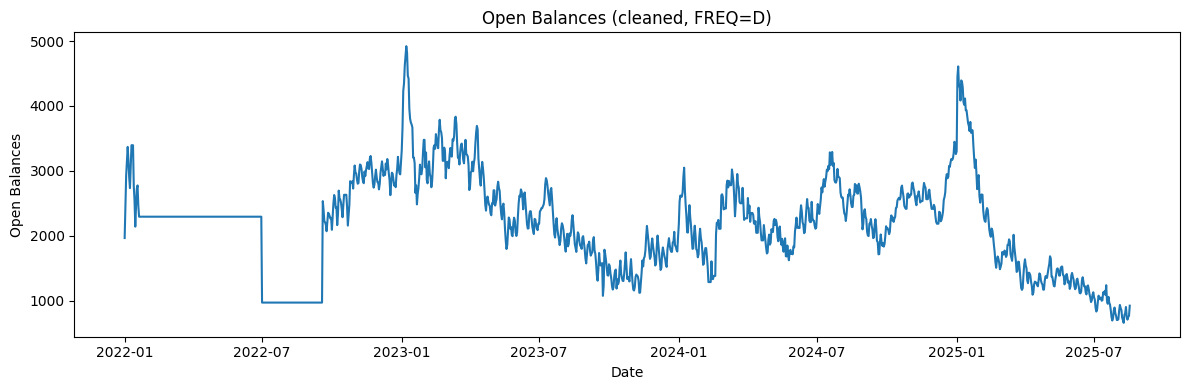

In [352]:
def resample_ts(df: pd.DataFrame, freq="D", agg="mean") -> pd.DataFrame:
    """
    Aggregate tidy DAILY df (ds,y) to a coarser freq for modeling.
    """
    if freq == "D":
        return df.sort_values("ds").reset_index(drop=True)
    s = df.set_index("ds").sort_index()["y"]
    if   agg == "mean":   g = s.resample(freq).mean()
    elif agg == "median": g = s.resample(freq).median()
    elif agg == "last":   g = s.resample(freq).last()
    else:
        raise ValueError("Unsupported 'agg'. Use 'mean'|'median'|'last'.")
    return g.dropna().to_frame("y").reset_index()

df_daily = read_clean_series(TXT_PATH)
df       = resample_ts(df_daily, freq=FREQ, agg=AGG)

print(f"Modeling range ({FREQ}):", df['ds'].min().date(), "→", df['ds'].max().date(), "| N:", len(df))

# preview
print("Daily cleaned series:")
display(df_daily.head())

print("Resampled series:")
display(df.head())

plt.figure(figsize=(12,4))
plt.plot(df["ds"], df["y"])
plt.title(f"Open Balances (cleaned, FREQ={FREQ})")
plt.xlabel("Date"); plt.ylabel("Open Balances")
plt.tight_layout(); plt.show()

#### Create “holiday” features for Dec–Jan spikes (recurring every year)

Add a Dec→Jan “holiday” window for daily data to capture year-end spikes.

If you choose weekly/monthly frequency, it skip explicit holidays and instead enable Prophet’s yearly seasonality (broad pattern only).

In [341]:
def build_year_end_holidays_daily(df: pd.DataFrame,
                                  lower_window=-14,
                                  upper_window=31,
                                  anchor_month=12,
                                  anchor_day=10,
                                  years_ahead=3) -> pd.DataFrame:
    min_y = int(df["ds"].dt.year.min())
    max_y = int(df["ds"].dt.year.max()) + years_ahead
    anchors = [pd.Timestamp(year=y, month=anchor_month, day=anchor_day)
               for y in range(min_y, max_y + 1)]
    return pd.DataFrame({
        "holiday": "year_end_spike",
        "ds": pd.to_datetime(anchors),
        "lower_window": lower_window,
        "upper_window": upper_window,
    })

if FREQ.split('-')[0] == "D":
    holidays = build_year_end_holidays_daily(
        df, lower_window=-14, upper_window=31, anchor_month=12, anchor_day=10
    )
else:
    holidays = None
print("Holidays is None?", holidays is None)


Holidays is None? False | weekly_flag: True | yearly_flag: False


#### Train/Validation Split & Baseline Model

- Split by calendar days (the last VALIDATION_DAYS go to validation).
- Fit a baseline Prophet model and compute MAE/RMSE/MAPE.

#### About changepoints
Prophet automatically proposes internal changepoints where the trend can bend.
changepoint_prior_scale (CPS) controls how flexible those bends can be:
- Lower CPS → smoother trend (less reactive)
- Higher CPS → more flexible (can overfit)


We’ll grid-search a few CPS values next.

In [342]:
# Split using DAILY window, then resample both sides to the modeling FREQ
cutoff_date = df_daily["ds"].max() - pd.Timedelta(days=VALIDATION_DAYS)

daily_train = df_daily[df_daily["ds"] <= cutoff_date].copy()
daily_valid = df_daily[df_daily["ds"]  > cutoff_date].copy()

df_train = resample_ts(daily_train, freq=FREQ, agg=AGG)
df_valid = resample_ts(daily_valid, freq=FREQ, agg=AGG)

print("Train:", df_train["ds"].min().date(), "→", df_train["ds"].max().date(), "(", len(df_train), "rows )")
print("Valid:", df_valid["ds"].min().date(), "→", df_valid["ds"].max().date(), "(", len(df_valid), "rows )")

def make_model(cps: float) -> Prophet:
    m = Prophet(
        weekly_seasonality=False,      # we add explicit components below
        yearly_seasonality=False,      # "
        daily_seasonality=False,
        changepoint_prior_scale=cps,
        seasonality_mode=SEASONALITY_MODE,
        interval_width=0.8,
        holidays=holidays,             # <-- ensure year-end spike window is used
    )
    # Add components only when resolvable at the chosen FREQ.
    if FREQ.startswith("D"):
        if USE_WEEKLY:
            m.add_seasonality(name="weekly",    period=7,      fourier_order=6,  prior_scale=10)
        if USE_MONTHLY:
            m.add_seasonality(name="monthly",   period=30.5,   fourier_order=10, prior_scale=10)
        if USE_QUARTERLY:
            m.add_seasonality(name="quarterly", period=91.25,  fourier_order=8,  prior_scale=10)
    if USE_YEARLY:
        m.add_seasonality(name="yearly",        period=365.25, fourier_order=10, prior_scale=10)
    return m

# Baseline model
m_base = make_model(CHANGEPOINT_PRIOR_SCALE)
m_base.fit(df_train)
future_valid = m_base.make_future_dataframe(periods=len(df_valid), freq=FREQ)
fc_valid = m_base.predict(future_valid)

19:21:45 - cmdstanpy - INFO - Chain [1] start processing


Train: 2022-01-01 → 2025-05-19 ( 1235 rows )
Valid: 2025-05-20 → 2025-08-17 ( 90 rows )


19:21:45 - cmdstanpy - INFO - Chain [1] done processing


#### Metrics and Quick Plot

Validation MAE : 180.39
Validation RMSE: 221.65
Validation MAPE: 16.09 %


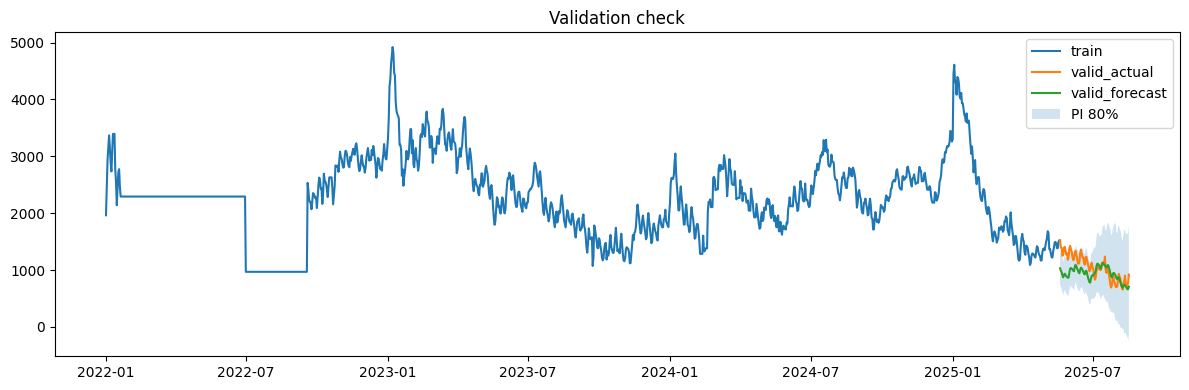

In [343]:
# Metrics
def mae(a,f): return float(np.mean(np.abs(np.array(a)-np.array(f))))
def rmse(a,f): return float(np.sqrt(np.mean((np.array(a)-np.array(f))**2)))
def mape(a,f):
    a,f = np.array(a),np.array(f)
    mask = a!=0
    return float(np.mean(np.abs((a[mask]-f[mask])/a[mask]))*100)

eval_df = df_valid.merge(fc_valid[["ds","yhat","yhat_lower","yhat_upper"]], on="ds", how="left")
print("Validation MAE :", round(mae(eval_df['y'], eval_df['yhat']), 2))
print("Validation RMSE:", round(rmse(eval_df['y'], eval_df['yhat']), 2))
print("Validation MAPE:", round(mape(eval_df['y'], eval_df['yhat']), 2), "%")

# Quick plot
plt.figure(figsize=(12,4))
plt.plot(df_train["ds"], df_train["y"], label="train")
plt.plot(df_valid["ds"], df_valid["y"], label="valid_actual")
plt.plot(eval_df["ds"], eval_df["yhat"], label="valid_forecast")
plt.fill_between(eval_df["ds"], eval_df["yhat_lower"], eval_df["yhat_upper"], alpha=0.2, label="PI 80%")
plt.title("Validation check"); plt.legend(); plt.tight_layout(); plt.show()

#### Grid Search: changepoint_scale
Try a small set of CPS values and pick the one minimizing MAE on the validation window.

In [344]:
cps_grid = [0.01, 0.05, 0.1, 0.2, 0.3, 0.5]
results = []

for cps in cps_grid:
    m = make_model(cps)
    m.fit(df_train)
    f = m.predict(m.make_future_dataframe(periods=len(df_valid), freq=FREQ))
    tmp = df_valid.merge(f[["ds","yhat"]], on="ds", how="left")
    mae = float(np.mean(np.abs(tmp["y"] - tmp["yhat"])))
    rmse = float(np.sqrt(np.mean((tmp["y"] - tmp["yhat"])**2)))
    mape = float(np.mean(np.abs((tmp["y"] - tmp["yhat"]) / np.where(tmp["y"]==0, np.nan, tmp["y"]))) * 100)
    results.append({"cps": cps, "MAE": mae, "RMSE": rmse, "MAPE": mape})

grid_df = pd.DataFrame(results).sort_values("MAE")
display(grid_df)
best_cps = float(grid_df.iloc[0]["cps"])
print("Best changepoint_prior_scale:", best_cps)

19:21:45 - cmdstanpy - INFO - Chain [1] start processing
19:21:45 - cmdstanpy - INFO - Chain [1] done processing
19:21:46 - cmdstanpy - INFO - Chain [1] start processing
19:21:46 - cmdstanpy - INFO - Chain [1] done processing
19:21:46 - cmdstanpy - INFO - Chain [1] start processing
19:21:46 - cmdstanpy - INFO - Chain [1] done processing
19:21:46 - cmdstanpy - INFO - Chain [1] start processing
19:21:46 - cmdstanpy - INFO - Chain [1] done processing
19:21:47 - cmdstanpy - INFO - Chain [1] start processing
19:21:47 - cmdstanpy - INFO - Chain [1] done processing
19:21:47 - cmdstanpy - INFO - Chain [1] start processing
19:21:48 - cmdstanpy - INFO - Chain [1] done processing


,cps,MAE,RMSE,MAPE
3,0.20,180.392194,221.654245,16.092120
4,0.30,188.304227,226.059027,17.123993
5,0.50,201.927186,237.167653,18.628089
2,0.10,274.608237,293.334788,25.933812
1,0.05,311.172144,325.339378,30.012419
0,0.01,851.590473,865.181034,86.254903


Best changepoint_prior_scale: 0.2


#### Final Fit, Forecast, and CSV Exports

Refit on all history using the best CPS, forecast FORECAST_PERIODS into the future at the chosen frequency, and save two CSVs:

- Full history + forecast
- Next horizon only

19:21:58 - cmdstanpy - INFO - Chain [1] start processing
19:21:58 - cmdstanpy - INFO - Chain [1] done processing


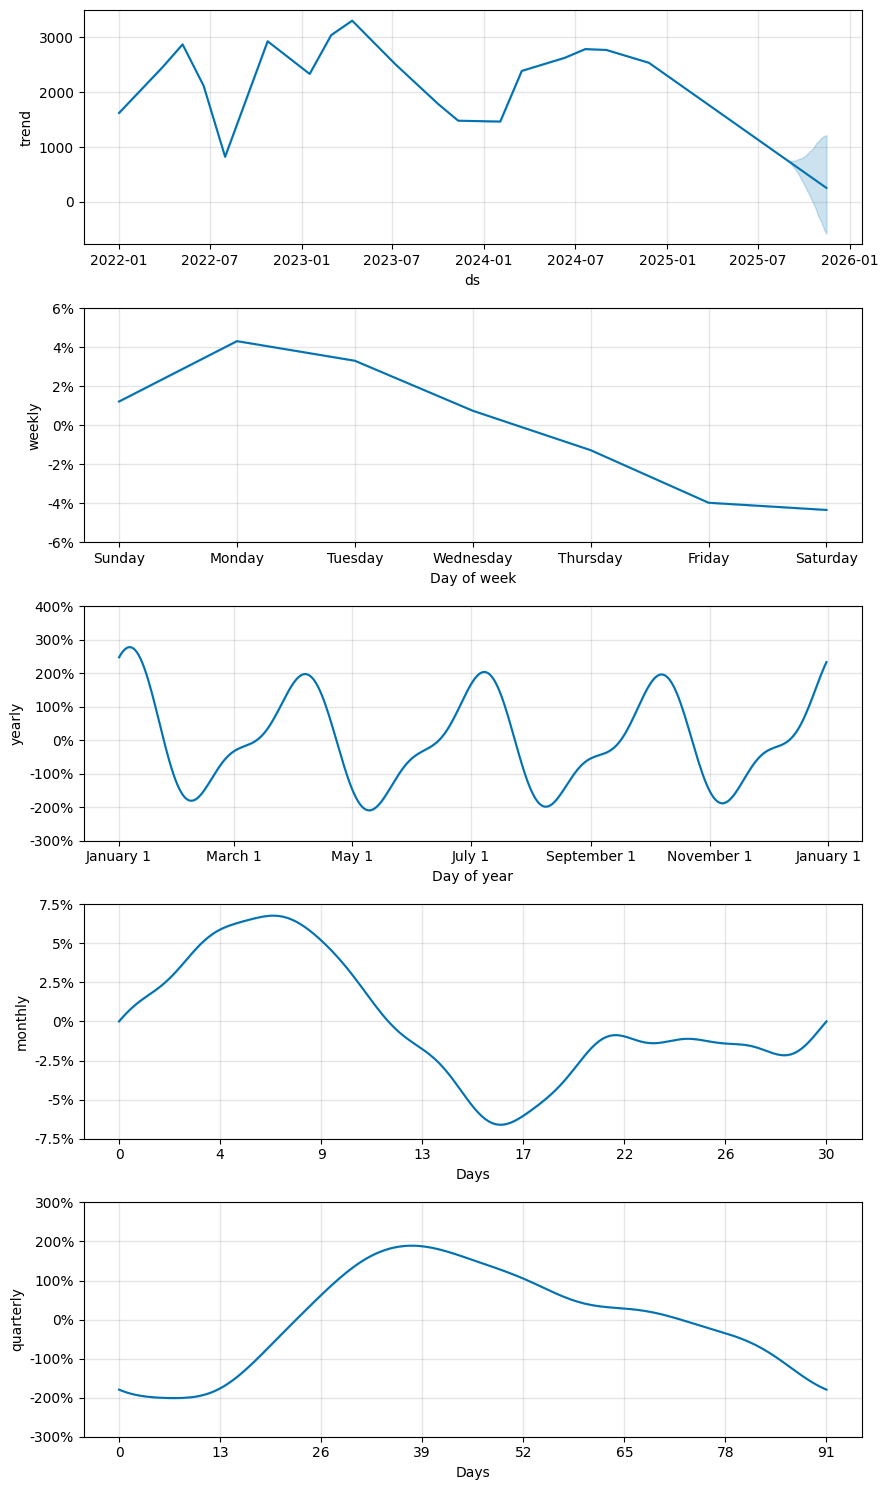

In [347]:
m_final = make_model(best_cps)
m_final.fit(df)

future   = m_final.make_future_dataframe(periods=FORECAST_PERIODS, freq=FREQ)
forecast = m_final.predict(future)

# Join back to actuals for plotting/export
out = forecast[["ds","yhat","yhat_lower","yhat_upper"]].merge(df[["ds","y"]], on="ds", how="left")

# Standard Prophet component plot (will include any added seasonalities)
_ = m_final.plot_components(forecast)
plt.show()

# Optional: show all seasonalities together with consistent y-axis percent scaling
# (Prophet already plots each; keeping the default is usually enough.)

#### Save Outputs

In [ ]:
# Save outputs (optional but handy)
# out.to_csv(f"open_balances_{FREQ.lower()}_fitted_and_forecast.csv", index=False)
# forecast.tail(FORECAST_PERIODS)[["ds","yhat","yhat_lower","yhat_upper"]].to_csv(
#     f"open_balances_{FREQ.lower()}_{FORECAST_PERIODS}_periods.csv", index=False
# )
# print("Saved CSVs for fitted+forecast and just the forecast tail.")